In [1]:
import numpy as np
import pandas as pd

import psutil
import GPUtil

import os,sys,humanize,psutil,GPUtil

import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import matplotlib.image as mpimg
import imageio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset  # Import the Dataset class

In [ ]:
def distribute_images():
    test_fold = 10
    
    # 데이터베이스(csv 파일) 로드
    df_db = pd.read_csv('/home/ines/code/ptb-xl/ptbxl_database.csv', index_col='ecg_id')
    # ASMI를 포함하는 인덱스
    asmi_indices = df_db[df_db['scp_codes'].str.contains('ASMI', na=False)].index
    # ASMI가 아닌 인덱스
    normal_indices = df_db[~df_db.index.isin(asmi_indices)].index

    df_st = pd.read_csv('/home/ines/code/ptb-xl/scp_statements.csv', index_col=0)
    df_st = df_st[df_st.diagnostic == 1]


    source_dir = f"/home/ines/code/ptb-xloooo/data_LeadV1/"
    train_dir_asmi = f'/home/ines/code/ptb-xl/X_train_V1/asmi/'
    train_dir_normal = f'/home/ines/code/ptb-xl/X_train_V1/normal/'
    test_dir_asmi = f'/home/ines/code/ptb-xl/X_test_V1/asmi/'
    test_dir_normal = f'/home/ines/code/ptb-xl/X_test_V1/normal/'
    
    # ASMI 이미지 이동
    for i in asmi_indices:
        five_digit_value = '%05d' % i
        file_name = five_digit_value + ".npy"
        if df_db.loc[i, 'strat_fold'] != test_fold :
            destination_path = os.path.join(train_dir_asmi, file_name)
        else:
            destination_path = os.path.join(test_dir_asmi, file_name)
        shutil.move(os.path.join(source_dir, file_name), destination_path)

    # ASMI가 아닌 이미지 이동
    for n in normal_indices:
        five_digit_value = '%05d' % n
        file_name = five_digit_value + ".npy"
        if df_db.loc[n, 'strat_fold'] != test_fold :
            destination_path = os.path.join(train_dir_normal, file_name)
        else:
            destination_path = os.path.join(test_dir_normal, file_name)
        shutil.move(os.path.join(source_dir, file_name), destination_path)


# 이미지 분배 함수 호출
distribute_images()

In [ ]:
import glob
import os
import wfdb
import numpy as np
from scipy.signal import resample

def downsample_ecg(record_path, downsampled_length=500):
    """
    ECG 데이터를 다운샘플링합니다.
    
    Parameters:
    - record_path: 읽을 .dat 파일의 경로(확장자 없이)
    - downsampled_length: 다운샘플링 후의 데이터 길이
    
    Returns:
    - downsampled_data: 다운샘플링된 데이터 (각 채널에 대한 결과를 리스트로 반환)
    """
    record = wfdb.rdrecord(record_path)
    downsampled_data = []
    for i in range(record.p_signal.shape[1]):  # 모든 채널에 대해 처리
        channel_data = record.p_signal[:, i]
        downsampled_channel_data = resample(channel_data, downsampled_length)
        downsampled_data.append(downsampled_channel_data)
    
    return downsampled_data

def process_and_save_dat_files(src_dir, dest_dir, downsampled_length=500):
    """
    주어진 디렉토리의 모든 .dat 파일에 대해 다운샘플링을 수행하고, 결과를 저장합니다.
    
    Parameters:
    - src_dir: .dat 파일이 위치한 소스 디렉토리 경로
    - dest_dir: 처리된 파일을 저장할 목적지 디렉토리 경로
    - downsampled_length: 다운샘플링 후의 데이터 길이
    """
    # 소스 디렉토리 검증
    if not os.path.exists(src_dir):
        print(f"Source directory {src_dir} does not exist.")
        return

    # 목적지 디렉토리 생성
    os.makedirs(dest_dir, exist_ok=True)

    # 소스 디렉토리에서 .dat 파일 검색
    for filepath in glob.glob(os.path.join(src_dir, '*.dat')):
        record_name = os.path.splitext(os.path.basename(filepath))[0]
        record_path = os.path.join(src_dir, record_name)
        downsampled_data = downsample_ecg(record_path, downsampled_length)

        # 다운샘플링된 데이터를 목적지 디렉토리에 저장
        save_path = os.path.join(dest_dir, f"{record_name}_downsampled.npy")
        np.save(save_path, np.array(downsampled_data))
        print(f"Saved downsampled data to {save_path}")

# 소스 디렉토리와 목적지 디렉토리 경로 설정
src_dir = '/home/ines/code/ptb-xl/X_train_pre/asmi/'  # 예: '/path/to/your/source_directory'
dest_dir = '/home/ines/code/ptb-xl/X_train/asmi/'  # 예: '/path/to/your/destination_directory'

process_and_save_dat_files(src_dir, dest_dir)

In [2]:
train_dir = os.path.join('/home/ines/code/ptb-xl/X_train/')
test_dir = os.path.join('/home/ines/code/ptb-xl/X_test/')

In [3]:
import glob

class TimeSeriesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): 'asmi'와 'normal' 폴더가 포함된 최상위 디렉토리 경로.
            transform (callable, optional): 샘플에 적용될 선택적 변환.
        """
        self.transform = transform
        self.samples = []

        # asmi 폴더의 파일에 라벨 1 할당
        asmi_files = glob.glob(os.path.join(root_dir, 'asmi', '*.npy'))
        self.samples.extend([(file, 1) for file in asmi_files])

        # normal 폴더의 파일에 라벨 0 할당
        normal_files = glob.glob(os.path.join(root_dir, 'normal', '*.npy'))
        self.samples.extend([(file, 0) for file in normal_files])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        # .npy 파일 로드
        data = np.load(file_path)
        
        # PyTorch 텐서로 변환
        data = torch.from_numpy(data).float()
        
        if self.transform:
            data = self.transform(data)
        
        return data, label


In [4]:
# 데이터셋 및 DataLoader 생성
train_da = TimeSeriesDataset(root_dir=train_dir)
test_da = TimeSeriesDataset(root_dir=test_dir)

train_dl = DataLoader(train_da, batch_size=64, shuffle=True, num_workers=4)
test_dl = DataLoader(test_da, batch_size=64, shuffle=True, num_workers=4)

In [5]:
for text, label in train_dl:
    print(label)
    break

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [6]:
'''
class ECGTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, num_classes):
        super(ECGTransformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, src):
        # src expected shape: [batch, channels, seq_len] => [64, 12, 500]
        # Permute src to [seq_len, batch, channels] => [500, 64, 12]
        src = src.permute(2, 0, 1)
        out = self.transformer_encoder(src)
        # Assuming you want to average across the sequence dimension
        out = torch.mean(out, dim=0)
        return self.fc(out)

# Model initialization adjusted for 12 channels as features
model = ECGTransformer(input_dim=12, num_heads=4, num_layers=2, num_classes=1)
'''

'\nclass ECGTransformer(nn.Module):\n    def __init__(self, input_dim, num_heads, num_layers, num_classes):\n        super(ECGTransformer, self).__init__()\n        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)\n        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)\n        self.fc = nn.Linear(input_dim, num_classes)\n    \n    def forward(self, src):\n        # src expected shape: [batch, channels, seq_len] => [64, 12, 500]\n        # Permute src to [seq_len, batch, channels] => [500, 64, 12]\n        src = src.permute(2, 0, 1)\n        out = self.transformer_encoder(src)\n        # Assuming you want to average across the sequence dimension\n        out = torch.mean(out, dim=0)\n        return self.fc(out)\n\n# Model initialization adjusted for 12 channels as features\nmodel = ECGTransformer(input_dim=12, num_heads=4, num_layers=2, num_classes=1)\n'

In [7]:
# Step 3: Training
'''
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):  # Loop over the dataset multiple times
    for inputs, labels in train_dl:
        inputs, labels = inputs.to(device), labels.to(device)  # Move tensors to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)  # If inputs are already in the correct shape, no need to unsqueeze
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    '''

'\ncriterion = nn.BCELoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=0.001)\n\nfor epoch in range(20):  # Loop over the dataset multiple times\n    for inputs, labels in train_dl:\n        inputs, labels = inputs.to(device), labels.to(device)  # Move tensors to the same device as the model\n        optimizer.zero_grad()\n        outputs = model(inputs)  # If inputs are already in the correct shape, no need to unsqueeze\n        loss = criterion(outputs, labels.unsqueeze(1).float())\n        loss.backward()\n        optimizer.step()\n    print(f"Epoch {epoch+1}, Loss: {loss.item()}")\n    '

In [8]:
# Step 4: Evaluation (simplified for demonstration)
'''
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.unsqueeze(-1))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on test data: {100 * correct // total} %')
'''

"\ncorrect = 0\ntotal = 0\nwith torch.no_grad():\n    for inputs, labels in test_loader:\n        outputs = model(inputs.unsqueeze(-1))\n        _, predicted = torch.max(outputs.data, 1)\n        total += labels.size(0)\n        correct += (predicted == labels).sum().item()\n\nprint(f'Accuracy of the model on test data: {100 * correct // total} %')\n"

In [9]:
class ECGTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, num_classes=1):
        super(ECGTransformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        # Assuming that after processing we want a single scalar for each item in the batch
        # We use input_dim * sequence_length because we're going to flatten the output of the transformer
        self.fc = nn.Linear(input_dim * 500, num_classes)  # Adjust the multiplication factor according to your sequence length

    def forward(self, src):
        # src shape: [batch_size, channels, seq_len] -> [64, 12, 500]
        # Permuting and flattening to treat each channel's time step as separate feature
        src = src.permute(2, 0, 1)  # New shape: [seq_len, batch_size, channels] -> [500, 64, 12]
        out = self.transformer_encoder(src)
        # Flattening the output for the fully connected layer
        out = out.permute(1, 0, 2).flatten(start_dim=1)  # [64, 500*12]
        out = self.fc(out)  # [64, 1]
        out = torch.sigmoid(out)
        return out

In [10]:
# Parameters initialization
input_dim = 12  # Number of channels
num_heads = 4
num_layers = 2

model = ECGTransformer(input_dim=input_dim, num_heads=num_heads, num_layers=num_layers, num_classes=1)

In [11]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
model.to(device)

device

device(type='cuda')

In [12]:
def l2_regularization(model, lambda_reg):
    l2_reg = None
    for W in model.parameters():
        if l2_reg is None:
            l2_reg = W.norm(2)
        else:
            l2_reg = l2_reg + W.norm(2)
    return lambda_reg * l2_reg

In [14]:
# Define Loss and Optimizer
criterion = nn.BCELoss()  # This loss combines a Sigmoid layer and the BCELoss in one single class
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

y_pred = []
y_true = []
tr_acc = []
valid_acc = []
tr_loss = []
valid_loss = []


for epoch in range(500):  # Loop over the dataset multiple times
    total_correct = 0
    total_samples = 0
    total_loss_epoch = 0
    for inputs, labels in train_dl:
        inputs, labels = inputs.to(device), labels.to(device)  # Move tensors to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)  # If inputs are already in the correct shape, no need to unsqueeze
        
        predicted = (outputs >= 0.5).float()  # 0.5를 기준으로 클래스를 나눕니다
        correct = (predicted.squeeze(1) == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)        
        
        loss = criterion(outputs, labels.unsqueeze(1).float())
        acc = 100 * total_correct / total_samples
        loss.backward()
        optimizer.step()
        total_loss_epoch += loss.item()

    avg_loss_epoch = total_loss_epoch / len(train_dl)
    acc = 100 * total_correct / total_samples
    tr_acc.append(acc)
    tr_loss.append(avg_loss_epoch)
    print(f'Epoch {epoch+1}: loss {avg_loss_epoch: .4f}, Accuracy {acc: .2f}%')


    model.eval()
    with torch.no_grad():
        val_tot_correct = 0
        val_tot_samples = 0
        for images, labels in test_dl:
            images, labels = images.to(device), labels.to(device)
            val_outputs = model(images)

            val_pred = (val_outputs >= 0.5).float().squeeze(1) # Make sure this results in a 1D tensor

            lab = labels.cpu().numpy()
            y_pred.append(val_pred)
            y_true.append(labels)
            
            val_cor = (val_pred == labels).sum().item()
            val_tot_correct += val_cor
            val_tot_samples += labels.size(0)

            val_loss = criterion(val_outputs, labels.unsqueeze(1).float())
    val_acc = 100 * val_tot_correct / val_tot_samples
    valid_acc.append(val_acc)
    valid_loss.append(val_loss.item())
    print(f'val_loss {val_loss: .4f}, Val_Accuracy {val_acc: .2f}%')
    print("lr: ", optimizer.param_groups[0]['lr'])
    scheduler.step()

Epoch 1: loss  0.3103, Accuracy  88.50%
val_loss  0.1795, Val_Accuracy  89.90%
lr:  0.001
Epoch 2: loss  0.2785, Accuracy  89.46%
val_loss  0.6506, Val_Accuracy  89.81%
lr:  0.00095
Epoch 3: loss  0.2659, Accuracy  89.68%
val_loss  0.2628, Val_Accuracy  90.54%
lr:  0.0009025
Epoch 4: loss  0.2360, Accuracy  90.53%
val_loss  0.2507, Val_Accuracy  90.54%
lr:  0.000857375
Epoch 5: loss  0.2086, Accuracy  91.48%
val_loss  0.1564, Val_Accuracy  90.76%
lr:  0.0008145062499999999
Epoch 6: loss  0.1999, Accuracy  92.10%
val_loss  0.2643, Val_Accuracy  91.72%
lr:  0.0007737809374999998
Epoch 7: loss  0.1839, Accuracy  92.59%
val_loss  0.2434, Val_Accuracy  90.22%
lr:  0.0007350918906249999
Epoch 8: loss  0.1712, Accuracy  93.15%
val_loss  0.4047, Val_Accuracy  91.36%
lr:  0.0006983372960937497
Epoch 9: loss  0.1615, Accuracy  93.40%
val_loss  0.1465, Val_Accuracy  91.54%
lr:  0.0006634204312890623
Epoch 10: loss  0.1493, Accuracy  93.81%
val_loss  0.4387, Val_Accuracy  91.36%
lr:  0.00063024940

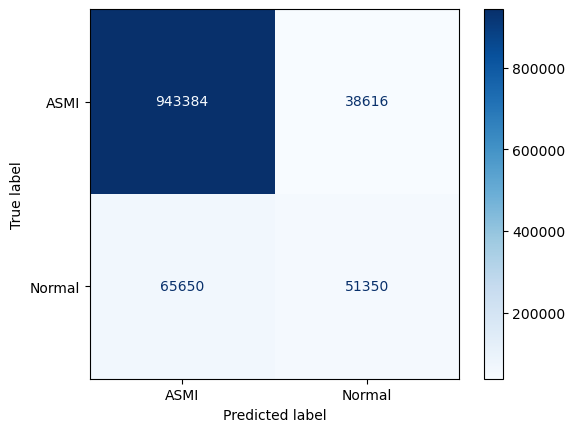

In [19]:
y_pred_tensor = torch.cat(y_pred).to('cpu')
y_true_tensor = torch.cat(y_true).to('cpu')

label_mapping = {'Normal': 0, 'ASMI': 1}

y_pred_numpy = y_pred_tensor.numpy()
y_true_numpy = y_true_tensor.numpy()

cm = confusion_matrix(y_true_numpy, y_pred_numpy)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ASMI', 'Normal'])

# True label 파랑색으로 설정
disp.plot(include_values=True, cmap='Blues', xticks_rotation='horizontal', values_format='d')
plt.show()


In [20]:
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")

Sensitivity (Recall): 0.4389
Specificity: 0.9607
Precision: 0.5708


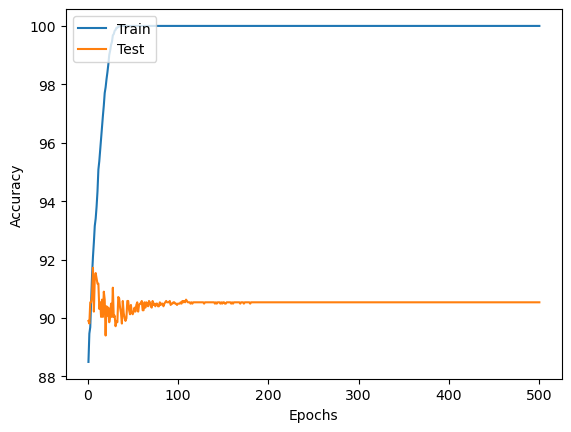

In [21]:
plt.plot(range(1,len(tr_acc)+1), tr_acc)
plt.plot(range(1,len(tr_acc)+1), valid_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

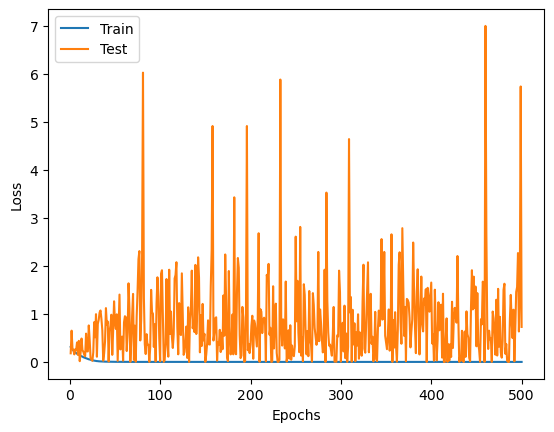

In [22]:
plt.plot(range(1,len(tr_acc)+1), tr_loss)
plt.plot(range(1,len(tr_acc)+1), valid_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
path = '/home/ines/code/ISOCC/model/tr_binary_12/'

torch.save(model, path + 'model.pt')
torch.save(model.state_dict(), path + 'model_state_dict.pt')
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, path + 'all.tar') 